# Import necessary libraries


In [1]:
from constants import *
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import *
from models import get_densenet_121, get_resnet_152, get_vgg_19
from generate_submittion import generate_submit, get_empty_submit, generate_one_model_submit
from train import train, show_train_images
import os
import torch
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image



# Prepare to train

In [2]:
# transforms
albu_transform = get_ablu_transform()
train_transform = get_exptrain_transform() #TODO #exp
val_transform = get_test_transform()

# replacers
label2int, int2label = get_label_replacers(TRAIN_DATAFRAME_PATH)


data = pd.read_csv(TRAIN_DATAFRAME_PATH)
data.label = data.label.replace(label2int)


# split data on train and validation
train_df, valid_df = train_test_split(data, test_size=.0001)

# create datasets
train_dataset = ImageDataset(train_df, FOLDER_PATH, train_transform, albu_transform)
val_dataset = ImageDataset(valid_df, FOLDER_PATH, val_transform)

# create loaders
train_loader = get_train_loader(train_dataset)
val_loader = get_test_loader(val_dataset)

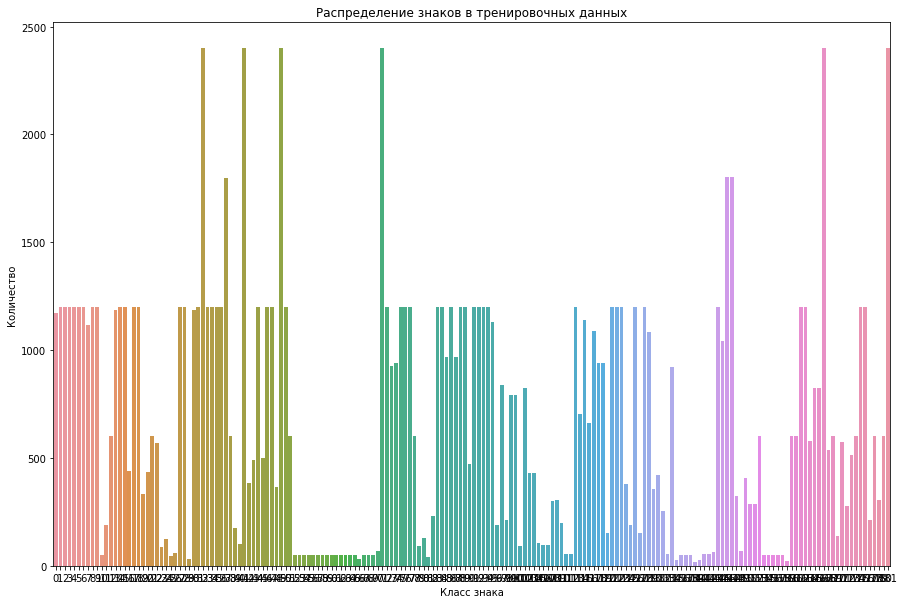

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title('Распределение знаков в тренировочных данных')
sns.countplot(data.label, ax=ax)
ax.set_xlabel('Класс знака')
ax.set_ylabel('Количество');

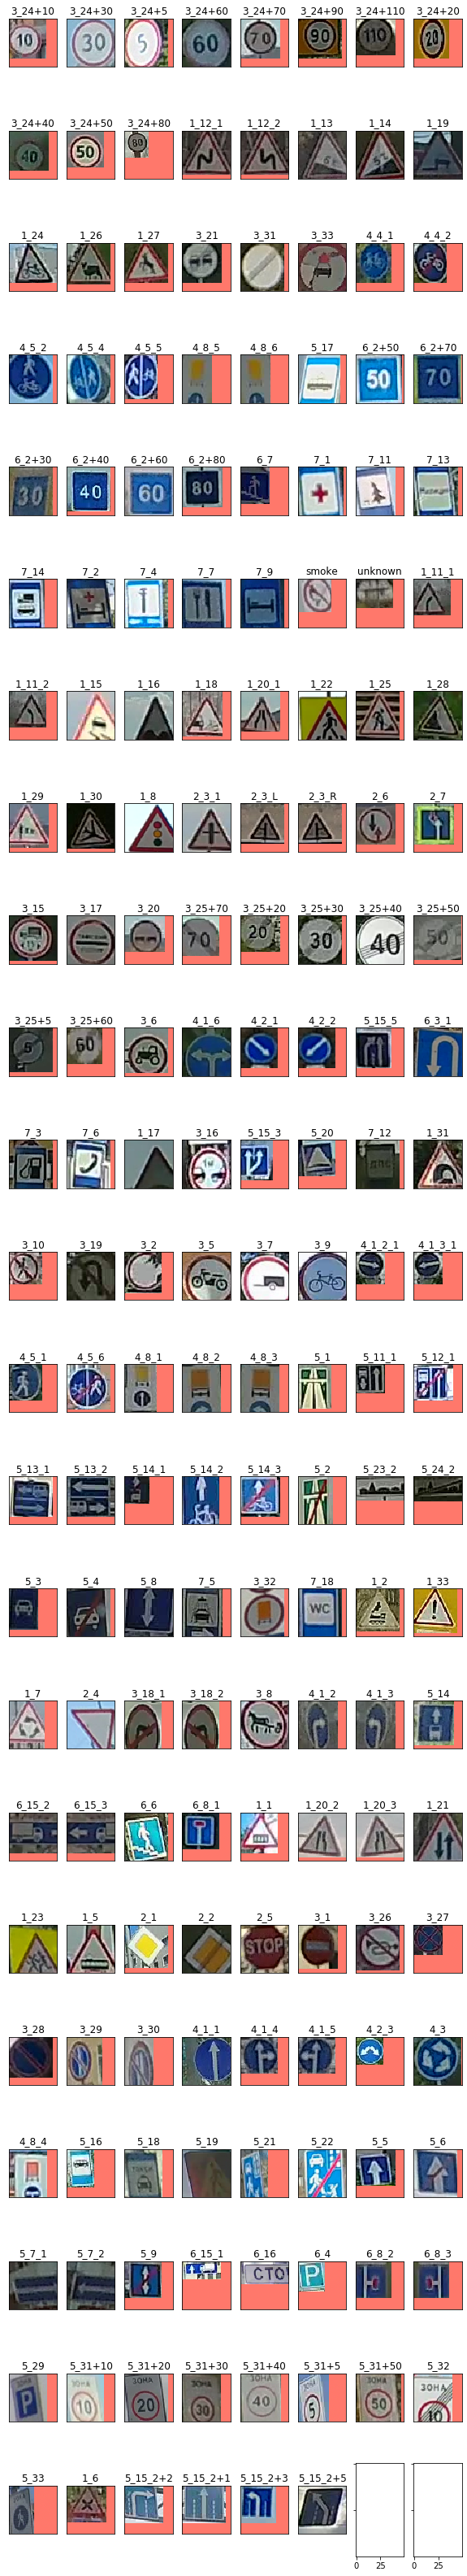

In [4]:
show_train_images()

# Upload models

Загружаем модели и подготавливаем их к тренировке

In [9]:
device = torch.device('cuda')
model = get_densenet_121(device)

lr = 0.0001

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr)
shed = torch.optim.lr_scheduler.StepLR(opt, 4)


train(model, loss_fn, opt, train_loader, val_loader, 15, device, '../checkpoints/conda_dense.ckpt' ,shed)

In [4]:
device = torch.device('cuda')
model = get_vgg_19(device)

lr = 0.0001

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr)
shed = torch.optim.lr_scheduler.StepLR(opt, 4)


train(model, loss_fn, opt, train_loader, val_loader, 15, device, '../checkpoints/conda_vgg.ckpt' ,shed)

Все модели тренировались в google colab, т.к. имеющиеся локальные машины не могли быть подвергнуты такой нагрузке\
При обучении моделей получаем следующие значения и графики

### First model

**f1_train 0.9866528178747557**\
**f1_test 0.991869918699187**


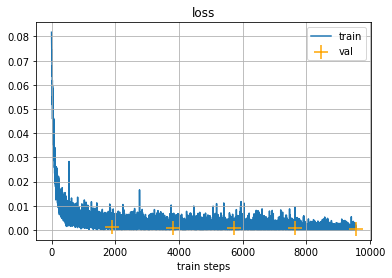
*Train loss: 0.008867260817465437*\
*Val loss: 0.02003923320986765*

### Second model

**f1_train 0.9918933149351828\
f1_test 0.998937908496732**

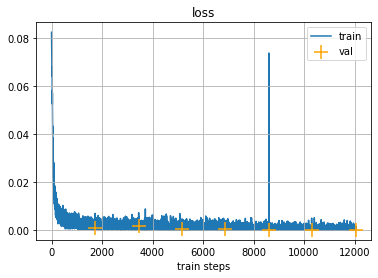

*Train loss: 0.05118643956055926\
Val loss: 0.0066821950377488025*

# Submition

In [5]:
val_transform = get_test_transform()
label2int, int2label = get_label_replacers(TRAIN_DATAFRAME_PATH)

zero = pd.read_csv(SAMPLE_SUBMISSION_PATH)


# create dataset and loader
test_dataset = TestDataset(zero,FOLDER_PATH, val_transform)
test_loader = get_test_loader(test_dataset)

# upload first model
model2 = get_vgg_19(DEVICE, '../checkpoints/vgg19exp(64,64).ckpt')

# upload second model
model = get_densenet_121(DEVICE, '../checkpoints/dense121exp(64,64).ckpt')


In [6]:
pr = generate_submit([model, model2], test_loader, '') # получаем предсказания нескольких моделей
zero.label = pr
zero.label = zero.label.replace(int2label)
zero.to_csv('../data/submit.csv', index=False)

100%|██████████| 31739/31739 [57:57<00:00,  9.13it/s]  
